In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
import os
from PIL import Image
import numpy as np
from collections import defaultdict
from torchvision.transforms.functional import to_tensor
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import timm
from tqdm import tqdm
from torch.utils.data import Dataset
import wandb


import pandas as pd

/Users/monika/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
!wandb login

/Users/monika/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/monika/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: xzjavkova (fiitnsiete). Use `wandb login --relogin` to force relogin


In [3]:
# Define the regex pattern for one or multiple spaces as the separator
separator_pattern = r'\s+'

# Define the column names
class_names = [
    'image_name',
    'person',
    'car',
    'building',
    'window',
    'tree',
    'sign',
    'door',
    'bookshelf',
    'chair',
    'table',
    'keyboard',
    'head'
]

# Read the CSV file using the regex pattern as the separator
train_labels = pd.read_csv('LabelMe-12-50k/train/annotation.txt', sep=separator_pattern, header=None, names=class_names, dtype={'image_name': str})
test_labels = pd.read_csv('LabelMe-12-50k/test/annotation.txt', sep=separator_pattern, header=None, names=class_names, dtype={'image_name': str})

train_labels = train_labels[train_labels.iloc[:, 1:].apply(lambda row: (row == 1).sum(), axis=1) == 1]

train_labels.replace(-1, 0, inplace=True)
test_labels.replace(-1, 0, inplace=True)

print(train_labels.shape)
train_labels.head()

(19997, 13)


,image_name,person,car,building,window,tree,sign,door,bookshelf,chair,table,keyboard,head
0,000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000002,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Count the number of "1" values for each class column
class_counts = train_labels.iloc[:, 1:].eq(1).sum()

# Display the counts
print(class_counts)

person       4856
car          3827
building     2085
window       4098
tree         1846
sign          951
door          830
bookshelf     391
chair         385
table         192
keyboard      324
head          212
dtype: int64


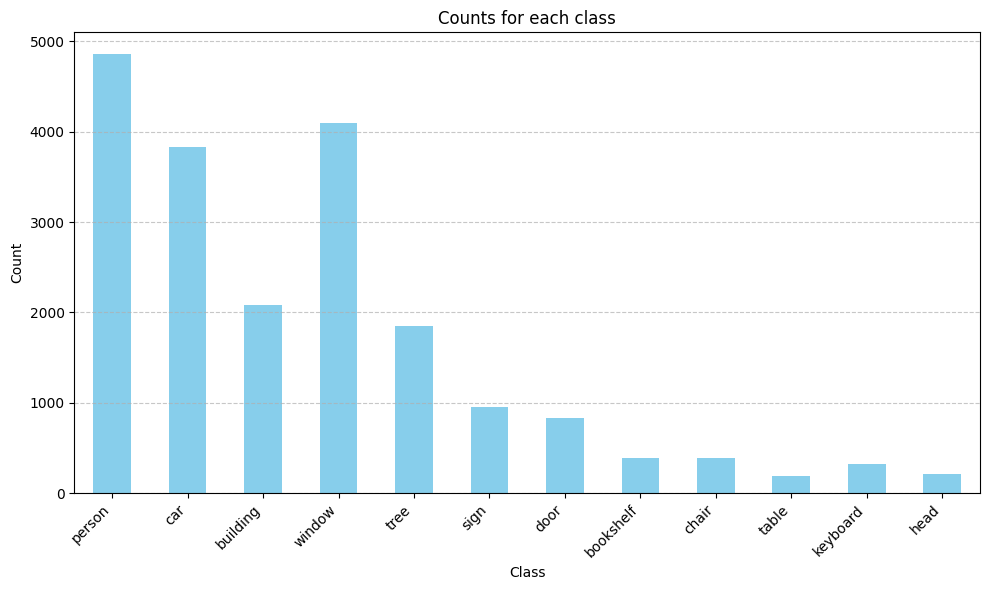

In [5]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_counts):
    # Plot the counts of "1" values for each class
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar', color='skyblue')
    plt.title('Counts for each class')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_class_distribution(class_counts)

In [6]:
# Determine desired number of samples for each class
desired_samples_per_class = 600 

# Find majority classes with counts higher than desired amount
majority_classes = [class_name for class_name in train_labels.columns if (train_labels[class_name] == 1).sum() > desired_samples_per_class]

# Undersample majority classes
undersampled_train_labels = train_labels.copy()
for class_name in majority_classes:
    # Get indices of samples with this class
    class_indices = train_labels[train_labels[class_name] == 1].index
    # Check if the number of samples for this class exceeds the desired amount
    if len(class_indices) > desired_samples_per_class:
        # Randomly select desired number of samples
        undersampled_indices = np.random.choice(class_indices, desired_samples_per_class, replace=False)
        # Update the undersampled labels
        undersampled_train_labels = undersampled_train_labels.drop(class_indices.difference(undersampled_indices))

undersampled_train_labels.head()

,image_name,person,car,building,window,tree,sign,door,bookshelf,chair,table,keyboard,head
4,000004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
14,000014,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
28,000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.04,0.0,0.0,0.0
33,000033,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
39,000039,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0


person       600
car          600
building     600
window       600
tree         600
sign         600
door         600
bookshelf    391
chair        385
table        192
keyboard     324
head         212
dtype: int64


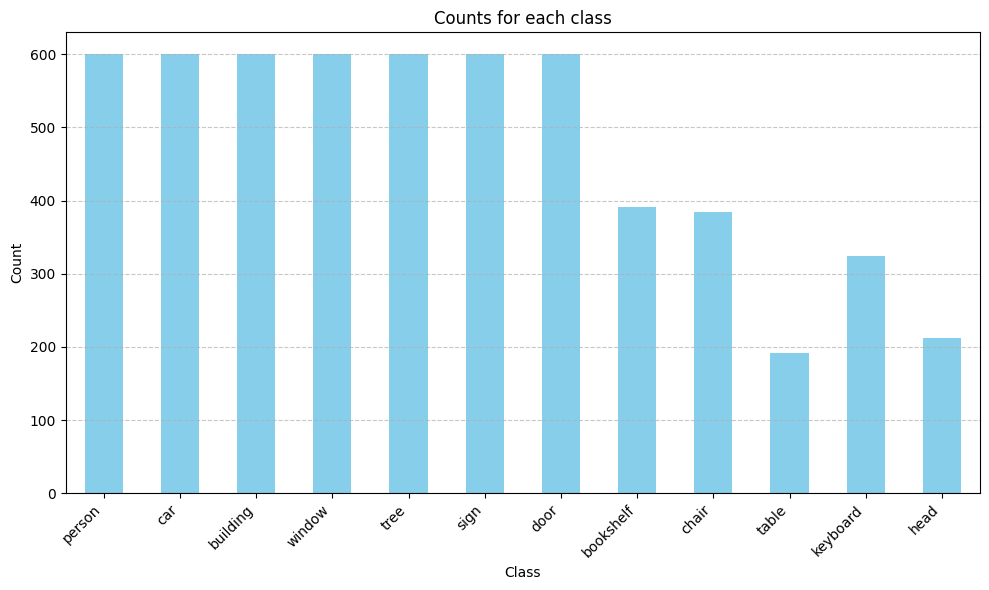

In [7]:
# Count the number of "1" values for each class column
class_counts_undersampled = undersampled_train_labels.iloc[:, 1:].eq(1).sum()

# Display the counts
print(class_counts_undersampled)

plot_class_distribution(class_counts_undersampled)

In [8]:

# Convert class labels to a PyTorch tensor
train_labels_tensor = torch.tensor(train_labels.iloc[:, 1:].values, dtype=torch.float32)

undersampled_train_labels_tensor = torch.tensor(undersampled_train_labels.iloc[:, 1:].values, dtype=torch.float32)

# Convert class labels to a PyTorch tensor
test_labels_tensor = torch.tensor(test_labels.iloc[:, 1:].values, dtype=torch.float32)

print(train_labels_tensor.shape)
print(undersampled_train_labels_tensor.shape)

torch.Size([19997, 12])
torch.Size([5704, 12])


In [9]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, tensor, root_dir, transform=None):
        self.labels = tensor
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = str(self.dataframe.iloc[idx, 0]) + '.jpg'  # Ensure img_name is a string
        subdir_name = '0' + str(self.dataframe.iloc[idx, 0])[:3]  # Extract first three characters of the image name
        img_path = os.path.join(self.root_dir, subdir_name, img_name)
        image = Image.open(img_path)
        label = self.labels[idx]  # Assuming the label column is in the second position

    

        if self.transform:
            image = self.transform(image)
        return image, label

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(10),       # Randomly rotate the image by a maximum of 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

In [11]:
train_data_path = "LabelMe-12-50k/train"
test_data_path = "LabelMe-12-50k/test"


train_dataset = ImageDataset(dataframe=train_labels, tensor = train_labels_tensor, root_dir=train_data_path, transform=transform)
test_dataset = ImageDataset(dataframe=test_labels, tensor = test_labels_tensor, root_dir=test_data_path, transform=test_transform)
undersampled_train_dataset = ImageDataset(dataframe=undersampled_train_labels, tensor=undersampled_train_labels_tensor, root_dir=train_data_path, transform=transform)

# Print number of images in each dataset
print("Number of images in train dataset:", len(train_dataset))
print("Number of images in undersampled dataset:", len(undersampled_train_dataset))
print("Number of images in test dataset:", len(test_dataset))
print("Shape of image", train_dataset[0][0].shape)

Number of images in train dataset: 19997
Number of images in undersampled dataset: 5704
Number of images in test dataset: 10000
Shape of image torch.Size([3, 256, 256])


In [12]:
train_dataset.labels.size()

torch.Size([19997, 12])

In [13]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
undersampled_loader = DataLoader(undersampled_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


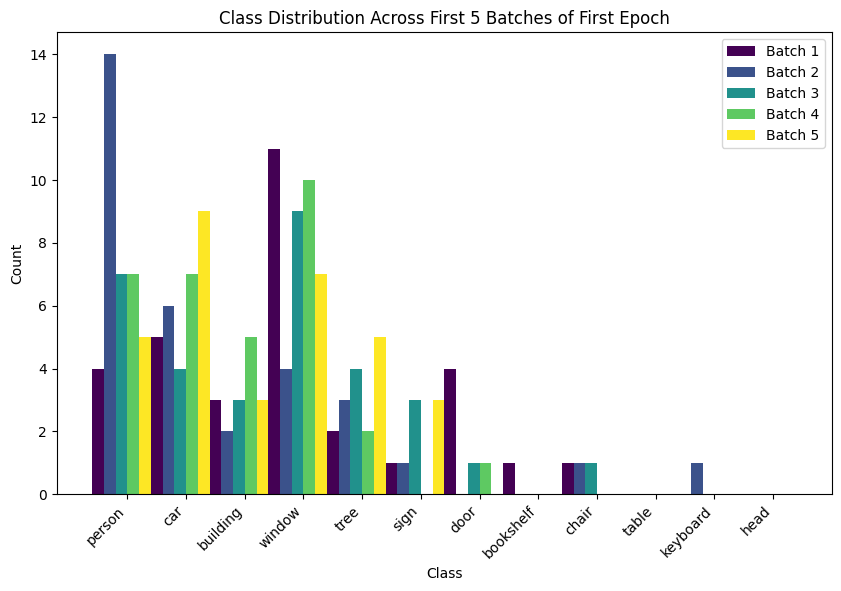

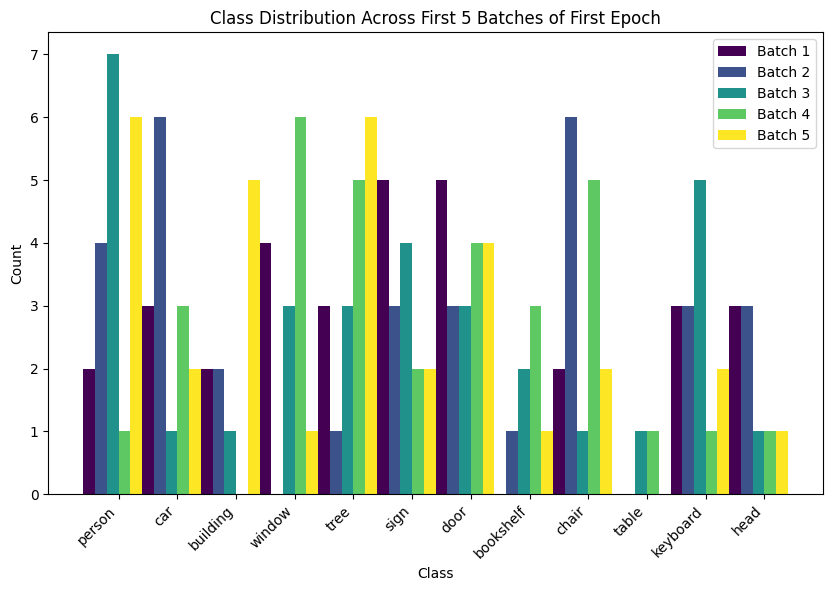

In [14]:
def plot_class_distribution_per_class(data_loader, class_names, num_batches=5):
    num_classes = len(class_names)
    class_counts_per_batch = np.zeros((num_batches, num_classes))

    batch_counter = 0
    for _, targets in data_loader:
        targets = targets.numpy()  # Convert targets tensor to NumPy array
        class_counts_per_batch[batch_counter] = np.sum(targets == 1, axis=0)  # Count non -1 elements for each class
        batch_counter += 1
        if batch_counter >= num_batches:
            break

    # Plotting
    colors = plt.cm.viridis(np.linspace(0, 1, num_batches))  # Generate colors for each batch
    fig, ax = plt.subplots(figsize=(10, 6))
    for i in range(num_batches):
        ax.bar(np.arange(num_classes) + i / num_batches, class_counts_per_batch[i], color=colors[i], width=1/num_batches, label=f'Batch {i+1}')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.set_title('Class Distribution Across First 5 Batches of First Epoch')
    ax.set_xticks(np.arange(num_classes) + 0.5)
    ax.set_xticklabels(class_names, rotation=45, ha='right')  # Rotate class names for better readability
    ax.legend()
    plt.show()


plot_class_distribution_per_class(train_loader, class_names[1:])
plot_class_distribution_per_class(undersampled_loader, class_names[1:])

In [15]:

class_counts = train_labels.drop(columns=['image_name']).sum()
total_samples = len(train_labels)
class_frequencies = class_counts / total_samples
inverse_frequencies = 1 / class_frequencies
total_inverse_frequency = inverse_frequencies.sum()
class_weights = inverse_frequencies / total_inverse_frequency
sample_weights = [0] * total_samples

# Convert class_weights to a list
class_weights_list = class_weights.values.tolist()

for idx, (_, label) in enumerate(train_dataset):
    # Convert one-hot encoded label tensor to a single integer label
    class_index = np.argmax(label)
    class_weight = class_weights_list[class_index]
    sample_weights[idx] = class_weight


# Create the WeightedRandomSampler
sampler = WeightedRandomSampler(sample_weights, total_samples, replacement=True)

loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

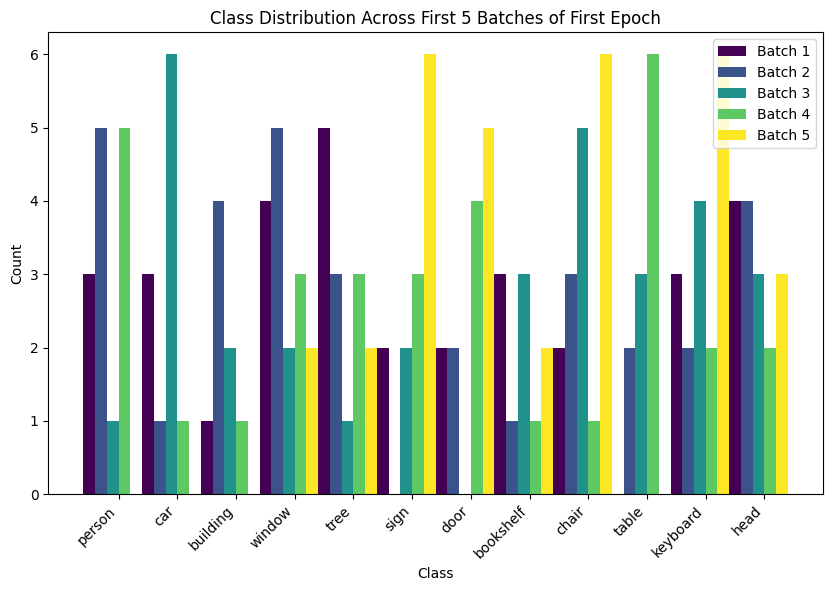

In [16]:
plot_class_distribution_per_class(loader, class_names[1:])

In [17]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Dynamic calculation of input size for fully connected layer
        self.fc_input_size = 64 * 8 * 8  # Initial assumption based on the initial calculation
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        # Dynamic calculation of input size for fully connected layer
        x = x.view(x.size(0), -1)
        if x.size(1) != self.fc_input_size:  # If input size changed, update fc1 layer
            self.fc_input_size = x.size(1)
            self.fc1 = nn.Linear(self.fc_input_size, 512)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [18]:
class MLP(nn.Module):
  def __init__(self, nin, nhidden, nout):
    super().__init__()

    if (nhidden == 0):
      self.main = nn.Linear(nin, nout)
    else:
      self.main = nn.Sequential(
          nn.Linear(nin, nhidden),
          nn.BatchNorm1d(nhidden),
          nn.ReLU(),
          nn.Linear(nhidden, nout)
      )

  def forward(self, x):
    logits = self.main(x)
    return logits

class ConvModel(nn.Module):
    def __init__(self, chin, channels, num_hidden, num_classes):
        super().__init__()
        self.num_classes = num_classes

        def convblock(chin, chout, k, s, p):
            return nn.Sequential(
                nn.Conv2d(chin, chout,kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(chout),
                nn.ReLU()
            )
    
        self.feature_extractor = nn.Sequential(
            convblock(chin, channels, 5, 2, 2),
            convblock(channels, channels*2, 3, 2, 1),
            convblock(channels*2, channels*4, 3, 2, 1),
            convblock(channels*4, channels*8, 3, 2, 1),
            convblock(channels*8, channels*16, 3, 2, 1)
        )

        self.num_features = channels*16

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            MLP(
                nin=1*1*self.num_features,
                nhidden=num_hidden,
                nout=num_classes
            )
        )

    def forward(self, x):
        f = self.feature_extractor(x)
        logits = self.head(f)
        return logits

In [19]:
class PretrainedResNe18(nn.Module):
    def __init__(self, num_hidden, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.feature_extractor = timm.create_model("resnet18", pretrained=True)
        self.feature_extractor.reset_classifier(0, "")

        for p in self.feature_extractor.parameters():
            p.requires_grad = False

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            MLP(
                nin=1*1*self.feature_extractor.num_features,
                nhidden=num_hidden,
                nout=num_classes
            )
        )

    def forward(self, x):
        f = self.feature_extractor(x)
        logits = self.head(f)
        return logits

In [20]:
# Exclude 'image_name' column and convert dataframe to a tensor
labels_tensor = torch.tensor(train_labels.drop(columns=['image_name']).values)

# Count occurrences of each class
class_counts = torch.sum(labels_tensor, dim=0)

# Compute class frequencies
class_frequencies = class_counts.float() / torch.sum(class_counts)

# Compute class weights (inverse of class frequencies)
class_weights = 1.0 / class_frequencies

# Optionally, you can normalize the class weights to sum up to 1
class_weights /= torch.sum(class_weights)

cost_weights = class_weights

In [21]:

# Define a thresholding function based on class imbalance
def threshold(outputs, thresholds):
    probabilities = torch.sigmoid(outputs)
    for idx, (prob, threshold) in enumerate(zip(probabilities[0], thresholds)):
        if prob.item() >= threshold:
            probabilities[0][idx] = 1
        else:
            probabilities[0][idx] = 0
    return probabilities

In [22]:
class_counts = train_labels.iloc[:, 1:].eq(1).sum()

# Convert class counts to a dictionary
class_counts_dict = class_counts.to_dict()

# Calculate total samples
total_samples = sum(class_counts_dict.values())

# Calculate imbalance ratios
class_weights = {cls: total_samples / freq for cls, freq in class_counts_dict.items()}

# Define thresholds for each class based on their imbalance ratios
class_thresholds = {cls: 0.5 * weight / total_samples for cls, weight in class_weights.items()}

# Print the imbalance ratios and thresholds
print("Class Imbalance Ratios:")
print(class_weights)
print("\nClass Thresholds:")
print(class_thresholds)

Class Imbalance Ratios:
{'person': 4.117998352553542, 'car': 5.225241703684348, 'building': 9.590887290167865, 'window': 4.8796974133723765, 'tree': 10.83261105092091, 'sign': 21.0273396424816, 'door': 24.09277108433735, 'bookshelf': 51.14322250639386, 'chair': 51.94025974025974, 'table': 104.15104166666667, 'keyboard': 61.71913580246913, 'head': 94.3254716981132}

Class Thresholds:
{'person': 0.00010296540362438221, 'car': 0.0001306506401881369, 'building': 0.0002398081534772182, 'window': 0.00012201073694485114, 'tree': 0.00027085590465872155, 'sign': 0.0005257623554153524, 'door': 0.0006024096385542169, 'bookshelf': 0.001278772378516624, 'chair': 0.0012987012987012987, 'table': 0.002604166666666667, 'keyboard': 0.0015432098765432098, 'head': 0.0023584905660377358}


In [23]:
import torch

def train_loop(model, criterion, optimizer, thresholding = False, gpu = True):
    
    wandb.init(project='NNproj2', entity='stufiit' , name=f'{model.__class__.__name__}_base_model')

    train_losses = []

    # Define the device
    if gpu:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = "cpu"

    # Move model to the device
    model = model.to(device)

    num_epochs = 5
    for epoch in range(num_epochs):
        with tqdm(total=len(train_loader), position=0, leave=True) as pbar:
            for images, labels in train_loader:  

                optimizer.zero_grad()  # Zero the parameter gradients

                # Move data to the device
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                train_losses.append(loss.item())
                epoch_loss = sum(train_losses) / len(train_losses)
                

                if thresholding:
                    # Prediction with thresholding
                    with torch.no_grad():
                        # Apply thresholding based on class imbalance
                        thresholds = torch.tensor([class_thresholds[key] for key in class_counts_dict.keys()]).to(device)
                        thresholded_outputs = threshold(outputs, thresholds)
                        
                        _, predicted_indices = torch.max(thresholded_outputs, 1)
                else:
                     _, predicted_indices = torch.max(outputs, 1)

                total_predictions = labels.size(0)
                correct_predictions = (predicted_indices == torch.argmax(labels, dim=1)).sum().item()
                epoch_accuracy = correct_predictions / total_predictions
                
                wandb.log({"Epoch": epoch+1, "Avg. train loss": epoch_loss, "Accuracy": epoch_accuracy})

                # Update progress bar
                pbar.set_postfix_str(f"Epoch: {epoch+1}, Avg. train loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
                pbar.update(1)

    wandb.finish()


In [27]:
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import wandb

def testing_loop(model, test_loader, run_name, gpu=True):
    # Initialize wandb
    wandb.init(project="NNproj2", name=run_name)

    # Define the device
    device = torch.device("cuda" if gpu and torch.cuda.is_available() else "cpu")

    # Move model to the device
    model = model.to(device)

    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Set model to evaluation mode
    model.eval()

        # Define lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Define your testing loop
    with torch.no_grad():  # Disable gradient tracking during inference
        for batch_idx, (images, labels) in enumerate(test_loader):
            # Move data to the device (e.g., GPU)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)

            # Convert outputs and labels to numpy arrays
            batch_predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()
            batch_true_labels = labels.cpu().numpy()

            # Append batch labels to the lists
            predicted_labels.extend(batch_predicted_labels)
            true_labels.extend(np.argmax(batch_true_labels, axis=1))  # Convert one-hot encoded labels to single-class labels



    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')


    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')

    # Finish wandb run
    wandb.finish()


In [25]:
model = ConvModel(3, 16, 512, 12)
#criterion = nn.CrossEntropyLoss(weight=cost_weights)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loop(model, criterion, optimizer, thresholding=False)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/Users/monika/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
wandb: Currently logged in as: xzjavkova (stufiit). Use `wandb login --relogin` to force relogin


100%|██████████| 625/625 [05:37<00:00,  1.85it/s, Epoch: 5, Avg. train loss: 0.9240, Accuracy: 0.7931]


Accuracy,▁▃▂▄▄▅▄▄▅▅▅▆▆▆▅▆▆▅▄▇▆▇▇▅▆▆█▇█▄▆▇▇▆▆▆▇▇▆▇
Avg. train loss,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
Accuracy,0.7931
Avg. train loss,0.92397
Epoch,5


In [28]:
testing_loop(model, test_loader, "undersampling_model_test", gpu = True)

UnboundLocalError: local variable 'precision' referenced before assignment